##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D spatial understanding with Gemini

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Setup

### Install SDK

In [7]:
%pip install -U -q "google-genai>=1.16.0"

### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [5]:
from google.colab import userdata
import os

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key.

In [6]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select and configure a model

Spatial understanding works best [Gemini 2.0 Flash model](https://ai.google.dev/gemini-api/docs/models/gemini-v2). It's even better with 2.5 models like `gemini-2.5-pro` but slightly slower as it's a [thinking](./Get_started_thinking.ipynb) model.

Some features, like segmentation, only works with 2.5 models.

The [Object detection](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/examples/Object_detection.ipynb) contains good examples of what previous models were able to do.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [8]:
MODEL_ID = "gemini-3-flash-preview" # @param ["gemini-2.5-flash-lite", "gemini-2.5-flash", "gemini-2.5-pro", "gemini-2.5-flash-preview", "gemini-3-pro-preview"] {"allow-input":true, isTemplate: true}

### System instructions

 With the new SDK, the `system_instructions` and the `model` parameters must be passed in all `generate_content` calls, so let's save them to not have to type them all the time.

In [ ]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

In [ ]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

The system instructions are mainly used to make the prompts shorter by not having to reapeat each time the format. They are also telling the model how to deal with similar objects which is a nice way to let it be creative.

The [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) is using a different strategy with no system instructions but a longer prompt. You can see their full prompts by clicking on the "show raw prompt" button on the right. There no optimal solution, experiment with diffrent strategies and find the one that suits your use-case the best.

It is also recommend to always disable the [thinking](./Get_started_thinking.ipynb), as so far it adds latency without improving the results.

### Import

Import all the necessary modules.

In [9]:
import google.generativeai as genai
from PIL import Image

import io
import os
import requests
from io import BytesIO

# 新段落

零件标定尺寸: Width=192, Height=255
>>> [DEBUG] LLM 原始响应 (Response Text):
{"feasible_zones":[{"box_2d":[410,440,690,635],"recommended_rotation":0,"reason":"Large vertical gap in the center of the sheet, between the left gears and the right-side parts."},{"box_2d":[710,690,980,980],"recommended_rotation":90,"reason":"Spacious empty area in the bottom-right corner of the material sheet."}]}
>>> 发现 2 个潜在合理区域：
=== 黄色区域：Gemini 预测的可行域 | 内部零件：建议的放置方式 ===


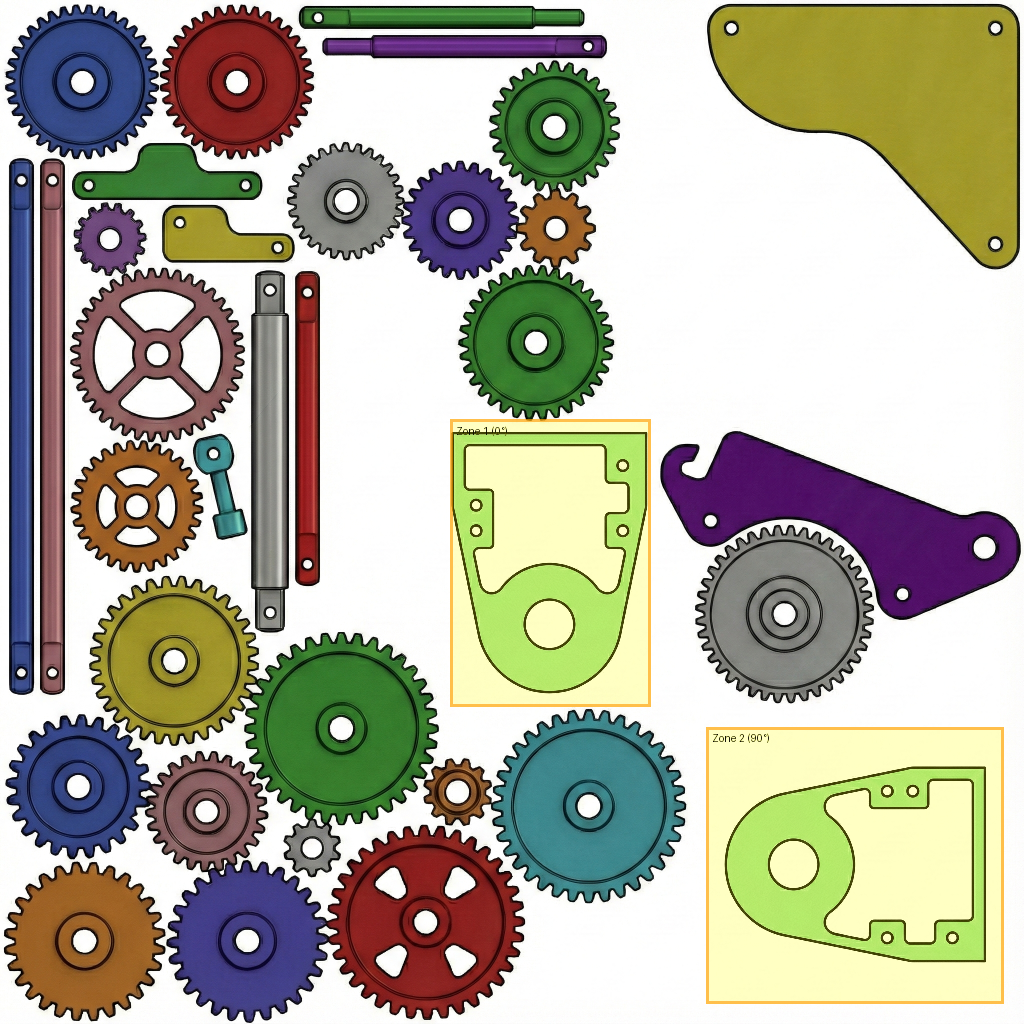

In [11]:
import base64
import json
import numpy as np
from PIL import Image, ImageDraw, ImageOps
from google.genai import types
from IPython.display import display

# ==========================================
# 1. 图像处理工具函数
# ==========================================

def make_white_transparent(image, threshold=240):
    img = image.convert("RGBA")
    data = np.array(img)
    r, g, b, a = data.T
    white_areas = (r >= threshold) & (g >= threshold) & (b >= threshold)
    data[..., 3][white_areas.T] = 0
    return Image.fromarray(data)

def crop_transparent_borders(image):
    img = image.convert("RGBA")
    alpha = img.split()[-1]
    bbox = alpha.getbbox()
    if bbox:
        return img.crop(bbox)
    return img

# ==========================================
# 2. 准备工作：加载与尺寸计算
# ==========================================

part_image_path = 'part_2.png'
sheet_image_path = 'sheet_3.png'

sheet_img = Image.open(sheet_image_path).convert("RGB")
raw_part = Image.open(part_image_path)

part_img_transparent = make_white_transparent(raw_part)
part_img = crop_transparent_borders(part_img_transparent)

sheet_w, sheet_h = sheet_img.size
part_w, part_h = part_img.size

# 归一化尺寸 (0-1000)
norm_w = int((part_w / sheet_w) * 1000)
norm_h = int((part_h / sheet_h) * 1000)

print(f"零件标定尺寸: Width={norm_w}, Height={norm_h}")

# ==========================================
# 3. 定义多区域 Response Schema
# ==========================================

response_schema = {
    "type": "OBJECT",
    "properties": {
        "feasible_zones": {
            "type": "ARRAY",
            "description": "List of all potential contiguous regions where the part can be placed.",
            "items": {
                "type": "OBJECT",
                "properties": {
                    "box_2d": {
                        "type": "ARRAY",
                        "description": "The bounding box [ymin, xmin, ymax, xmax] of the empty region.",
                        "items": {"type": "INTEGER"}
                    },
                    "recommended_rotation": {
                        "type": "INTEGER",
                        "description": "Best rotation (0, 90, 180, 270) to fit the part in this zone."
                    },
                    "reason": {
                        "type": "STRING",
                        "description": "Brief description of why this area is suitable."
                    }
                },
                "required": ["box_2d", "recommended_rotation"]
            }
        }
    },
    "required": ["feasible_zones"]
}

# ==========================================
# 4. Prompt 构建 (区域预测导向)
# ==========================================

system_inst = """
You are a spatial geometry expert for industrial nesting.
Your task: Identify ALL valid "Feasible Zones" on the Material Sheet (Image 1) for the New Part (Image 2).

**DEFINITIONS:**
- A "Feasible Zone" is a continuous whitespace area that is LARGE ENOUGH to contain the part's shape.
- The part's normalized size is approximately {norm_w} x {norm_h}.

**CRITICAL RULES:**
1. **FIND ALL:** Locate multiple distinct zones (e.g., top-left corner, gaps between gears, bottom edges).
2. **DIMENSION CHECK:** Each predicted [ymin, xmin, ymax, xmax] zone MUST have a width/height greater than or equal to the part's dimensions (considering rotation).
3. **NO OVERLAP:** The zone must not contain any pixels from existing colored objects in Image 1.
4. **MAXIMIZE UTILITY:** Define the zones as the largest possible empty rectangles available.
"""

prompt = f"""
Image 1: The Sheet with existing parts.
Image 2: The New Part to be nested.

**PART DIMENSIONS (0-1000 scale):**
- Original: {norm_w} (W) x {norm_h} (H)
- If rotated 90/270 deg: {norm_h} (W) x {norm_w} (H)

**INSTRUCTIONS:**
1. Scan the Sheet for all empty white spaces.
2. For each space, determine if the Part can fit inside.
3. Return the coordinates for ALL such regions as `feasible_zones`.
"""

# ==========================================
# 5. API 调用与可视化
# ==========================================

try:
    # 注意：此处假设你已按需配置好 client 和 MODEL_ID
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[prompt, sheet_img, part_img],
        config=types.GenerateContentConfig(
            system_instruction=system_inst,
            temperature=0.1,
            response_mime_type="application/json",
            response_schema=response_schema
        )
    )

    # --- 保留调试信息：打印原始响应 ---
    print(">>> [DEBUG] LLM 原始响应 (Response Text):")
    print(response.text)

    results = json.loads(response.text)
    zones = results.get("feasible_zones", [])

    # 准备画布
    final_visual = sheet_img.copy().convert("RGBA")
    overlay = Image.new("RGBA", final_visual.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)

    print(f">>> 发现 {len(zones)} 个潜在合理区域：")

    for i, zone in enumerate(zones):
        ymin, xmin, ymax, xmax = zone['box_2d']
        rot = zone['recommended_rotation']

        # 坐标转换
        left, top = (xmin / 1000) * sheet_w, (ymin / 1000) * sheet_h
        right, bottom = (xmax / 1000) * sheet_w, (ymax / 1000) * sheet_h

        # 1. 绘制可行域矩形 (半透明黄色)
        draw.rectangle([left, top, right, bottom], fill=(255, 255, 0, 60), outline=(255, 165, 0, 180), width=3)
        draw.text((left + 5, top + 5), f"Zone {i+1} ({rot}°)", fill=(0, 0, 0, 255))

        # 2. 在每个区域的中心模拟放一个缩略零件 (可选，用于验证)
        rotated_part = part_img.rotate(-rot, expand=True)
        # 简单缩放零件以适应区域（如果区域预测过小）
        target_w, target_h = int(right - left), int(bottom - top)
        # 这里仅作示意，实际排料不应缩放
        # rotated_part.thumbnail((target_w, target_h))

        px, py = int((left + right)/2 - rotated_part.size[0]/2), int((top + bottom)/2 - rotated_part.size[1]/2)
        # 确保粘贴坐标不越界
        final_visual.paste(rotated_part, (max(0, px), max(0, py)), mask=rotated_part.split()[3])

    # 合并图层
    final_visual = Image.alpha_composite(final_visual, overlay)

    print("=== 黄色区域：Gemini 预测的可行域 | 内部零件：建议的放置方式 ===")
    display(final_visual)

except Exception as e:
    print(f"执行失败: {e}")

# 新段落

In [19]:
from google import genai
from google.genai import types
import PIL.Image
import json

# === 1. 假设已经完成了初始化 (保持你原有的逻辑) ===
# 这里的 API_KEY 请替换为你实际的 Key，或者从环境变量读取
# client = genai.Client(api_key="YOUR_API_KEY")
# MODEL_ID = "gemini-2.0-flash-exp"

# === 2. 准备输入数据 ===
sheet_image_path = 'sheet_3.png'
try:
    sheet_img = PIL.Image.open(sheet_image_path)
except FileNotFoundError:
    print(f"错误: 找不到文件 {sheet_image_path}，请确保文件在当前目录下。")
    # 为了代码演示不中断，创建一个假图片 (实际使用时请忽略此行)
    sheet_img = PIL.Image.new('RGB', (1024, 1024), color='white')

# === 3. 定义结构化输出 (Schema) ===
# 我们强制模型返回一个对象列表，每个对象包含 box_2d (数组) 和 mask (字符串)
response_schema = types.Schema(
    type=types.Type.ARRAY,
    items=types.Schema(
        type=types.Type.OBJECT,
        properties={
            "box_2d": types.Schema(
                type=types.Type.ARRAY,
                items=types.Schema(type=types.Type.INTEGER),
                description="The bounding box of the region [ymin, xmin, ymax, xmax] in normalized coordinates (0-1000)."
            ),
            "mask": types.Schema(
                type=types.Type.STRING,
                description="A Base64 encoded PNG image string (data:image/png;base64,...) representing the binary mask of the empty region."
            ),
            "confidence": types.Schema(
                type=types.Type.NUMBER,
                description="Confidence score between 0 and 1."
            )
        },
        required=["box_2d", "mask"]
    )
)

# === 4. 定义 Prompt 和 System Instruction ===
system_inst = """
You are an expert industrial nesting engine. Your task is to analyze images of material sheets and identify "Usable Remnant Areas".
A Usable Remnant Area is a large, continuous white space where new parts can be placed.
You must ignore small gaps between existing parts and focus on the main open areas.
"""

prompt = """
Analyze the attached image.
1. Identify the largest continuous empty region (white space) suitable for placing new parts.
2. Generate a bounding box [ymin, xmin, ymax, xmax] for this region using normalized coordinates (0-1000).
3. Generate a binary mask for this region encoded as a Base64 PNG string.
   - The mask should be white for the empty usable area and black for everything else.
   - Keep the mask resolution moderate (e.g., maintain aspect ratio but scale down to fit within 256px) to ensure the Base64 string is valid and fits in the context.
   - The Base64 string must start with "data:image/png;base64,".
"""

# === 5. 调用 Gemini (你提供的代码段) ===
print(">>> 正在请求 Gemini 进行排料区域预测...")

try:
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[prompt, sheet_img],
        config=types.GenerateContentConfig(
            system_instruction=system_inst,
            temperature=0.2, # 稍微降低温度以提高坐标精确度和 Base64 字符串的稳定性
            response_mime_type="application/json",
            response_schema=response_schema
        )
    )

    # --- 保留调试信息：打印原始响应 ---
    print(">>> [DEBUG] LLM 原始响应 (Response Text):")
    print(response.text)

    prediction = json.loads(response.text)

    # === 6. 处理结果 ===
    if response.text:
        # 解析 JSON
        # prediction = json.loads(response.text)
        print(">>> 预测成功!")

        # 打印部分结果以验证
        for i, item in enumerate(prediction):
            print(f"\n--- 区域 {i+1} ---")
            print(f"Box 2D: {item.get('box_2d')}")
            mask_str = item.get('mask', '')
            print(f"Mask Base64 (前50字符): {mask_str[:50]}...")
            print(f"Mask Base64 长度: {len(mask_str)}")

            # 可以在这里添加代码将 Base64 保存为图片文件进行验证

    else:
        print(">>> 响应为空，可能被安全策略拦截或生成失败。")

except Exception as e:
    print(f">>> 发生错误: {e}")

>>> 正在请求 Gemini 进行排料区域预测...
>>> [DEBUG] LLM 原始响应 (Response Text):
[
  {
    "box_2d": [0, 310, 1000, 1000],
    "mask": "
>>> 发生错误: Unterminated string starting at: line 4 column 13 (char 54)


In [3]:
from google import genai
from google.genai import types
import PIL.Image
import json
import cv2
import numpy as np
import base64
import io

# === 初始化 (保持你的 client 配置) ===
# client = genai.Client(api_key="YOUR_API_KEY")
# MODEL_ID = "gemini-2.0-flash-exp"

sheet_image_path = 'sheet_3.png'
try:
    sheet_img = PIL.Image.open(sheet_image_path)
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

# === 1. 改进 Schema: 允许列表 ===
response_schema = types.Schema(
    type=types.Type.ARRAY,
    items=types.Schema(
        type=types.Type.OBJECT,
        properties={
            "region_id": types.Schema(type=types.Type.INTEGER),
            "box_2d": types.Schema(
                type=types.Type.ARRAY,
                items=types.Schema(type=types.Type.INTEGER),
                description="[ymin, xmin, ymax, xmax] normalized 0-1000"
            ),
            "mask_low_res": types.Schema(
                type=types.Type.STRING,
                description="Base64 encoded PNG of the binary mask. CRITICAL: The mask image MUST be resized to a maximum dimension of 64 pixels (tiny thumbnail) to save tokens."
            )
        },
        required=["region_id", "box_2d", "mask_low_res"]
    )
)

# === 2. 改进 System Instruction: 强调“独立区域” ===
system_inst = """
You are a nesting engine. Your goal is to find distinct, separated empty spaces on a material sheet.
CRITICAL RULE: Do not group separated empty spaces into one large box.
If a colored part sits between two white spaces, they are TWO DIFFERENT regions.
"""

# === 3. 改进 Prompt: 限制 Mask 大小 + 强制分块 ===
prompt = """
Analyze the image and find the top 3 distinct largest empty regions (white space) suitable for placing new parts.

Requirements:
1. **Separation**: Look for the red outline example in your training data concept. The regions are likely separated by the gears/parts in the middle. Identify the top-right, middle-right, and bottom-right areas as separate entities if they are divided by parts.
2. **Output**: Return a JSON list of exactly 3 regions (if applicable).
3. **Mask Format**: To prevent errors, the 'mask_low_res' MUST be a very low resolution PNG (max 64x64 pixels). Do NOT output a high-res mask. I will resize it later. The mask should be white for the empty area, black for others.
"""

print(f">>> 正在请求 {MODEL_ID}...")

try:
    response = client.models.generate_content(
        model=MODEL_ID,
        contents=[prompt, sheet_img],
        config=types.GenerateContentConfig(
            system_instruction=system_inst,
            temperature=0.4, # 稍微提高一点以增加多样性，帮助分割
            max_output_tokens=8192, # 拉满 Token 限制
            response_mime_type="application/json",
            response_schema=response_schema
        )
    )

    # --- 保留调试信息：打印原始响应 ---
    print(">>> [DEBUG] LLM 原始响应 (Response Text):")
    print(response.text)

    # === 4. 解析与后处理 ===
    if response.text:
        predictions = json.loads(response.text)
        print(f">>> 成功预测 {len(predictions)} 个区域!")

        # 读取原图用于绘制
        cv_img = cv2.imread(sheet_image_path)
        h, w = cv_img.shape[:2]

        for item in predictions:
            rid = item.get('region_id')
            box = item.get('box_2d')
            b64_mask = item.get('mask_low_res')

            print(f"正在处理区域 {rid}: Box {box}")

            # --- A. 绘制 Box ---
            ymin, xmin, ymax, xmax = box
            left, top = int(xmin * w / 1000), int(ymin * h / 1000)
            right, bottom = int(xmax * w / 1000), int(ymax * h / 1000)
            cv2.rectangle(cv_img, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(cv_img, f"ID:{rid}", (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

            # --- B. 处理 Mask (低清转高清) ---
            if b64_mask:
                try:
                    # 1. 解码 Base64
                    if "base64," in b64_mask:
                        b64_mask = b64_mask.split("base64,")[1]
                    mask_data = base64.b64decode(b64_mask)

                    # 2. 转为 numpy 图片 (此时是 64x64 这种小图)
                    nparr = np.frombuffer(mask_data, np.uint8)
                    mask_small = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

                    # 3. 关键步骤：拉伸回原图大小
                    # 使用 INTER_NEAREST 保持边缘锐利，或者 INTER_LINEAR 平滑
                    mask_full = cv2.resize(mask_small, (w, h), interpolation=cv2.INTER_LINEAR)

                    # 4. 叠加显示 (蓝色半透明)
                    # 阈值处理，确保 mask 是二值的
                    _, mask_bin = cv2.threshold(mask_full, 127, 255, cv2.THRESH_BINARY)

                    color_mask = np.zeros_like(cv_img)
                    color_mask[:, :] = [255, 0, 0] # 蓝色

                    # 仅在 mask 为白色的地方应用颜色
                    res_mask = cv2.bitwise_and(color_mask, color_mask, mask=mask_bin)
                    cv_img = cv2.addWeighted(cv_img, 1.0, res_mask, 0.5, 0) # 0.5 透明度

                except Exception as mask_err:
                    print(f"Mask解析失败: {mask_err}")

        # 保存结果
        cv2.imwrite("final_result_multi_region.jpg", cv_img)
        print(">>> 结果已保存为 final_result_multi_region.jpg")

    else:
        print(">>> 响应为空")

except Exception as e:
    print(f">>> 错误: {e}")

>>> 正在请求 gemini-3-flash-preview...
>>> 错误: name 'client' is not defined
